<a href="https://colab.research.google.com/github/kabatyy/deepCaptioning/blob/main/dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import subprocess
import torch
from data_loader import get_loader
from torchvision import transforms
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline
import nltk

In [2]:
GIT_REPO_URL = "https://github.com/kabatyy/deepCaptioning.git"
COCO_API_REPO = "https://github.com/cocodataset/cocoapi.git"
DIR = "/content/project"
CLONE_DIR = os.path.join(DIR, "deepCaptioning")

def clone_repo():
    os.makedirs(DIR, exist_ok = True)
    os.chdir(DIR)
    if os.path.exists(CLONE_DIR):
        print(f"Repo already exists at {CLONE_DIR}, skipping clone.")
    else:
        subprocess.run(["git", "clone", GIT_REPO_URL], check=True)
        print(f"Repository cloned. Cloning COCO API...")
        os.chdir("/content/project/deepCaptioning")
        subprocess.run(["git", "clone", COCO_API_REPO], check=True)

def process_dataset():
  subprocess.run(["python3", 'start.py'], check=True)
  print("Dataset processing completed.")

def install_cocoapi():
  os.chdir("/content/project/deepCaptioning/cocoapi/PythonAPI")
  subprocess.run(["make"], check=True)
  print("COCO API installation completed.")

In [3]:
print("Cloning repo...")
clone_repo()

Cloning repo...
Repository cloned. Cloning COCO API...


In [4]:
print("Processing dataset...")
process_dataset()

Processing dataset...
Dataset processing completed.


In [5]:
print("Installing COCO API...")
install_cocoapi()


Installing COCO API...
COCO API installation completed.


In [8]:
dataDir ="/content/project/deepCaptioning/cocoapi/annotations/annotations/annotations"#fix this path, bug in start.py
datatype='val2024'
instances_annFile = os.path.join(dataDir, 'instances_train2014.json'.format(datatype))
coco = COCO(instances_annFile)

captions_annFile = os.path.join(dataDir, 'captions_train2014.json'.format(datatype))
coco_caps = COCO(captions_annFile)

ids= list(coco.anns.keys())


loading annotations into memory...
Done (t=19.64s)
creating index...
index created!
loading annotations into memory...
Done (t=1.04s)
creating index...
index created!


http://images.cocodataset.org/train2014/COCO_train2014_000000287437.jpg


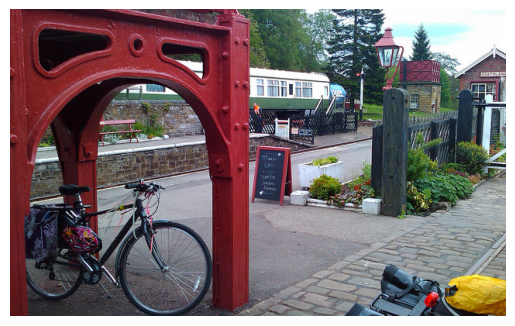

A bike parked under a red metal object.
Vintage train station with buildings, bike, and motorcycle.
A person's bike sitting at a train station.
A bicycle is under a large red structure.
a bike parked under a red structure near a building


In [9]:
# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

In [ ]:
# Watch for any changes in vocabulary.py, data_loader.py or model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

In [ ]:


# Define a transform to pre-process the training images.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Set the minimum word count threshold.
vocab_threshold = 5

# Specify the batch size.
batch_size = 10

# Obtain the data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=False)

In [ ]:
sample_caption = 'A person doing a trick on a rail while riding a skateboard.'

In [ ]:
sample_tokens = nltk.tokenize.word_tokenize(str(sample_caption).lower())
print(sample_tokens)

In [ ]:
sample_caption = []

start_word = data_loader.dataset.vocab.start_word
print('Special start word:', start_word)
sample_caption.append(data_loader.dataset.vocab(start_word))
print(sample_caption)

In [ ]:
sample_caption.extend([data_loader.dataset.vocab(token) for token in sample_tokens])
print(sample_caption)